In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, mean_squared_error
import shap

In [42]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F

In [43]:
from dataset import BldgDataset
from model import ClassificationModel, RegressionModel

In [69]:
def main():
    model_name = 'model_test'
    model_type = 'regression'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 8
    EPOCHS = 50
    lr = 5e-3
    l2_reg = 0.1

    data = pd.read_csv('data/data_df.csv', header=0)
    
    data = data.drop(['target'], axis=1)

    # TODO: Replace with cross validation
    test_df = data.sample(frac=0.2)
    data.drop(test_df.index, inplace=True)

    train_data = BldgDataset(data)
    test_data = BldgDataset(test_df)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)
    test_loader = DataLoader(test_data,
                             batch_size=batch_size*2,
                             shuffle=False)

    if model_type == 'regression':
        model = RegressionModel(in_feats=train_data.num_feats(),
                                hidden_dim=10,
                                dropout=0.2,
                                activation='relu')
    else:
        model = ClassificationModel(in_feats=train_data.num_feats(),
                                    hidden_dim=10,
                                    n_classes=train_data.num_classes(),
                                    dropout=0.2,
                                    activation='relu')
    optimizer = optim.Adam(model.parameters(),
                           lr=lr,
                           weight_decay=l2_reg)

    model.to(device)
    for epoch in range(EPOCHS):

        data_iter = tqdm(
            train_loader,
            desc=f'Epoch: {epoch:02}',
            total=len(train_loader)
        )

        model.train()
        avg_loss = 0.
        for i, (X, y) in enumerate(data_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits = model(X)
            # TODO: Find a loss function for ordinal classification
            if model_type == 'regression':
                loss = F.mse_loss(logits.squeeze(), y.type(torch.float32))
            else:
                loss = F.cross_entropy(logits, y)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            data_iter.set_postfix({
                'avg_loss': avg_loss / (i+1)
            })

    y_pred, y_true = [], []
    with torch.no_grad():
        model.eval()
        for X, y in test_loader:
            X = X.to(device)

            if model_type == 'regression':
                preds = model(X).squeeze()
            else:
                preds = torch.argmax(model(X), dim=-1)
            y_pred.extend(preds.cpu())
            y_true.extend(y)

    # TODO: Paper used MSE not accuracy
    if model_type == 'regression':
        print(f'Test MSE: {mean_squared_error(y_true, y_pred):.4f}')
    else:
        print(y_pred)
        print(y_true)
        print(f'Test Accuracy: {accuracy_score(y_true, y_pred):.4f}')
        print(f'Test MSE: {mean_squared_error(y_true, y_pred):.4f}')

    torch.save(model.state_dict(), f'models/{model_name}.pt')
    
    batch = next(iter(train_loader))
    images, _ = batch
    batch2 = next(iter(test_loader))
    images2, _ = batch2
    
    train_shap = images.to(device)
    test_shap = images2.to(device)
      
    explainer = shap.DeepExplainer(model, train_shap)
    shap_values = explainer.shap_values(test_shap)
    
    return shap_values
    

In [70]:
def ordinalize(x, n_classes=5):
    out = np.zeros(n_classes)
    for i in range(x):
        out[i] = 1
    return out

In [78]:
if __name__ == '__main__':
    shap_values = main()

Epoch: 49: 100%|█████████████████████████████████████████████████████| 12/12 [00:00<00:00, 164.83it/s, avg_loss=0.0236]

Test MSE: 0.0752


In [79]:
import matplotlib.pyplot as plt

In [126]:
shap_val = np.mean(np.abs(shap_values), axis=0)
shap_val

array([0.00860971, 0.00369374, 0.02255591, 0.01075809, 0.00630561,
       0.00018412, 0.00309517, 0.00161897, 0.0056296 ])

In [137]:
y_bar = []
for i in range(len(shap_val)):
    y_bar.append('Feature '+str(i))

In [138]:
df = pd.DataFrame({'shap': shap_val, 'feature': y_bar})

In [139]:
df = df.sort_values(by='shap', ascending=True)

In [140]:
shap_val = list(df['shap'])
y_bar = list(df['feature'])
y_pos = np.arange(len(y_bar))

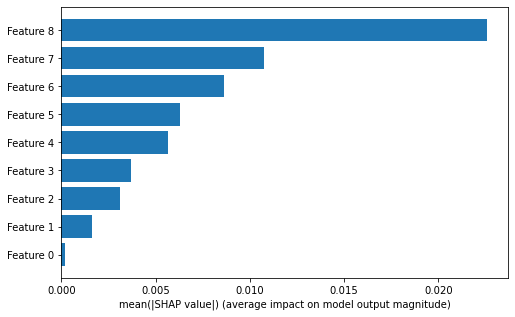

In [141]:
plt.figure(figsize=(8,5))
plt.barh(y_pos, shap_val)
plt.yticks(y_pos, y_bar)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
plt.savefig('deepshap/shap_contribution_model8.png')
